In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


# Work Extension https://www.kaggle.com/rohandx1996/v-auto-encoder-vs-frauds-on-imbalance-data-wins

### so here in this kernel i would like demonstrate some advance methods of Tensorflow framework to fasten up training process with parallelization of cpu gpu schedulling with primary focus on data engg (tf records) and tf.data api (data input pipelines)

![](https://pbs.twimg.com/media/D_6npzuUIAA3WZG.jpg)

So guys my above kernel explains why I have chosen auto-encoder as for classifying fraud cases but as you can see that training of this model requires lot of computation time atleast 45 minutes on kaggle's gpu.
we have to move towards some faster solution not to save our training time but to save company resources as well sometimes even in kaggle competition time contsraint issues can be solved if training can be done much more faster ways

* but is just not about winining kaggle competition it is about real time working (model deployment should be done in Tensorflow)

* because in the end it's all about scalability ,  request response in real-time and model's reliablity over it's metrics

### let's start with explaining what advance methods we will be using and it's code implication part 
### so that you won't miss any of it 

1. #### Step 1 : Script to split data in train test and validation data 
1. #### Step 2 : Conversion of data dirs to Tf records (data engg)
1. #### Step 3 : Using tf.data api for construction of data input pipeline (data engg)
1. #### Step 4 : tf.flags and namescopes are indeed for naming of layers hyper-parameter initialization 
1. #### Step 5 : Some more methods how we can speed up cpu gpu scheduling (feeding Steriods)

### we will be first writing script to split our dataset in 3 parts train , test , validation after that it will be converted in Tf records

# What are tf records ? how it help us to optimize computaiton power ?

A TFRecord file stores your data as a sequence of binary strings. This means you need to specify the structure of your data before you write it to the file. Tensorflow provides two components for this purpose: tf.train.Example and tf.train.SequenceExample. You have to store each sample of your data in one of these structures, then serialize it and use a tf.python_io.TFRecordWriter to write it to disk.

If you are working with large datasets, using a binary file format for storage of your data can have a significant impact on the performance of your import pipeline and as a consequence on the training time of your model. Binary data takes up less space on disk, takes less time to copy and can be read much more efficiently from disk. This is especially true if your data is stored on spinning disks, due to the much lower read/write performance in comparison with SSDs.

However, pure performance isn’t the only advantage of the TFRecord file format. It is optimized for use with Tensorflow in multiple ways. To start with, it makes it easy to combine multiple datasets and integrates seamlessly with the data import and preprocessing functionality provided by the library. Especially for datasets that are too large to be stored fully in memory this is an advantage as only the data that is required at the time (e.g. a batch) is loaded from disk and then processed. Another major advantage of TFRecords is that it is possible to store sequence data — for instance, a time series or word encodings — in a way that allows for very efficient and (from a coding perspective) convenient import of this type of data. Check out the Reading Data guide to learn more about reading TFRecord files.

![](http://digital-thinking.de/wp-content/uploads/2019/07/KerasGPU.gif)
#### with keras gpu utlization it shows gpu is waiting for something but what it is actually is the data which need to get preprocessed first

![](http://digital-thinking.de/wp-content/uploads/2019/07/tensorflow.gif)
### with tensorflow records gpu utilization (apart from that we use other methods)to control cpu and gpu to make this parallelization process to achieve next level

# Spliting

### Splitting Dataset as per requirement for training this auto-encoder (reason of split already explained in my earlier notebooks link given above)

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

train_data_dir='../input/creditcardfraud/creditcard.csv'

def get_data():
    
    # Import the csv data as pands's dataframe
    data=pd.read_csv(train_data_dir)
    min_max_scaler=MinMaxScaler()
    #Create an instance of sklearn's MinMaxScalar and use it to map the feature values in the range [0,1]
    df_cred=data.drop("Time",axis=1)
    df_cred_scaled = min_max_scaler.fit_transform(df_cred.iloc[:,:-1])
    df_cred_normalized = pd.DataFrame(df_cred_scaled)
    
    df_cred_normalized["Class"]=df_cred["Class"]
    
    print("class count : ",df_cred_normalized["Class"].value_counts())
    
    # train and test splits process initiated 
    df_cred_normalized_train=df_cred_normalized[df_cred_normalized["Class"]==0]
    df_cred_normalized_test=df_cred_normalized[df_cred_normalized["Class"]==1]
    
    # taking out 10 percent sample out of train set and to feed in test and validation set  
    df_cred_normalized_test_part_1=df_cred_normalized_train.sample(frac=0.05)
    df_cred_normalized_train=df_cred_normalized_train.drop(df_cred_normalized_test_part_1.index)
    df_cred_normalized_test_part_2=df_cred_normalized_train.sample(frac=0.05)
    df_cred_normalized_train=df_cred_normalized_train.drop(df_cred_normalized_test_part_2.index)
    
    # frauds cases in test and validation set as dicsussed earlier 
    df_cred_normalized_test_class_1=df_cred_normalized_test.sample(frac=0.5)
    df_cred_normalized_validation_class_1=df_cred_normalized_test.drop(df_cred_normalized_test_class_1.index)
    
    print("fraud cases shape : ",df_cred_normalized_test_class_1.shape)
    
    df_cred_normalized_test_set=df_cred_normalized_test_part_1.append(df_cred_normalized_test_class_1)
    df_cred_normalized_validation_set=df_cred_normalized_test_part_2.append(df_cred_normalized_validation_class_1)
    
    print("train set dimensions :",df_cred_normalized_train.shape)
    print("test set dimensions :",df_cred_normalized_test_set.shape)
    print("validate set dimensions :",df_cred_normalized_validation_set.shape)
    
    print("class counts on validation set")
    print(df_cred_normalized_validation_set["Class"].value_counts())
    
    x_train, x_test = train_test_split(df_cred_normalized_train, test_size=0.2, random_state=2020)
    x_train = x_train[x_train.Class == 0]
    y_train = x_train["Class"]
    x_train = x_train.drop(['Class'], axis=1)
    y_test = x_test['Class']
    x_test = x_test.drop(['Class'], axis=1)
    x_train = x_train.values
    x_test = x_test.values
    print("train data set shape")
    print(x_train.shape)
    print("test data set shape")
    print(x_test.shape)
    y_train = y_train.values
    y_test = y_test.values
    
    x_val_set_1=df_cred_normalized_test_set.iloc[:,:-1]
    y_val_set_1=df_cred_normalized_test_set["Class"]
    x_val_set_1=x_val_set_1.values
    y_val_set_1=y_val_set_1.values
    
    x_val_set_2=df_cred_normalized_validation_set.iloc[:,:-1]
    y_val_set_2=df_cred_normalized_validation_set["Class"]
    x_val_set_2=x_val_set_2.values
    y_val_set_2=y_val_set_2.values
        
    return [x_train, y_train], [x_test, y_test] ,[x_val_set_1,y_val_set_1],[x_val_set_2,y_val_set_2]

# TF Record writer

In [3]:
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import sys
from random import shuffle
import pandas as pd

In [4]:
rm -rf "/kaggle/working/tf_records_root_dir/"

In [5]:
os.mkdir("/kaggle/working/tf_records_root_dir")
os.mkdir("/kaggle/working/tf_records_root_dir/tf_records_train")
os.mkdir("/kaggle/working/tf_records_root_dir/tf_records_test")
os.mkdir("/kaggle/working/tf_records_root_dir/tf_records_validation_set_1")
os.mkdir("/kaggle/working/tf_records_root_dir/tf_records_validation_set_2")

In [6]:
def float_feature(value):
    ''' Helper function that wraps float features into the tf.train.Feature class 
    
    @param value: the feature or label of type float, that we want to convert 
    '''
    
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def int64_feature(value):
    ''' Helper function that wraps integer features into the tf.train.Feature class 
    
    @param value: the feature or label of type integer, that we want to convert 
    '''
    
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def write_tf_records_file(x, y, tf_writer,data_type):
    '''This function writes a feature-label pair to a TF-Records file
    
    @param x: the feature
    @param y: the label
    @ tf_writer: the TensorFlow Records writer instance that writes the files
    '''
    
    # Convert numpy array to list, because tf.train.Feature accepts only lists
    x=x.tolist()
    #Features we want to convert to the binary format
    feature_dict={ 'features': float_feature(x),
                   'labels': float_feature(y),                         
                 }

    #Another wrapper class
    features_wrapper=tf.train.Features(feature=feature_dict) 
    # Aaaand another wrapper class lol
    example = tf.train.Example(features=features_wrapper)

    # Finally we make the files binary and write them to TF-Records file
    tf_writer.write(example.SerializeToString())



def run(tf_records_dir, data, data_type=None):
    '''Main function for the writing process
    
    @param tf_records_dir: path where the files should be written into
    @param data: the dataset that contains the features and labels
    '''
    
    # If the directory is not present, create one
    
      
    #Get the features and labels from the dataset
    features=data[0]
    labels=data[1]
    # Number of instances in the dataset
    n_data_instances=features.shape[0]
    # Initialize a counter for the data instances
    data_instance_counter=0
    
    # Specify the number of samples that will be saved in one TF-Records file
    samples_per_file=500
    
    # Number of all TF-Records files in the end
    n_tf_records_files=round(n_data_instances/samples_per_file)
    # Counter for the TF-Records files
    tf_records_counter=0
    
   
    #Iterate over the number of total TF-Records files
    while tf_records_counter < n_tf_records_files:

        # Give each file an unique name(full-path)
        tfrecords_file_name='%s/%s_%i.tfrecord' % (tf_records_dir, data_type, tf_records_counter)

        #Initialize a writer for the files
        with tf.python_io.TFRecordWriter(tfrecords_file_name) as tf_writer:
            
            sample_counter=0

            #Iterate over all data samples and number of samples per TF-Records file
            while data_instance_counter<n_data_instances and sample_counter<samples_per_file:
                
                sys.stdout.write('\r>> Converting data instance %d/%d' % (data_instance_counter+1, n_data_instances))
                sys.stdout.flush()
 
                # Extract a feature instance
                x=features[data_instance_counter]
                # Extract a label instance
                y=labels[data_instance_counter]
                
                # Write feature and label to a TF-Records file
                write_tf_records_file(x,y,tf_writer,data_type)

                # Increase the counters
                data_instance_counter+=1
                sample_counter+=1
                
            tf_records_counter+=1
            
    print('\nFinished converting the dataset!')
    
    
if __name__ == "__main__":
    
    # Build the paths for the training, test, and validation TF-Records files
    tf_records_root_dir='/kaggle/working/tf_records_root_dir/'
    train_dir = os.path.join(tf_records_root_dir, 'tf_records_train')
    test_dir = os.path.join(tf_records_root_dir, 'tf_records_test')
    validation_dir_set_1 = os.path.join(tf_records_root_dir, 'tf_records_validation_set_1')
    validation_dir_set_2 = os.path.join(tf_records_root_dir, 'tf_records_validation_set_2')
    
    # Get the preprocessed data 
    train_data, test_data ,validation_set_1,validation_set_2=get_data()    
    #Write for each dataset TF-Records file
    run(train_dir, train_data, data_type='training')
    run(test_dir, test_data, data_type='test')
    run(validation_dir_set_1, validation_set_1, data_type='validation_1')
    run(validation_dir_set_2, validation_set_2, data_type='validation_2')

class count :  0    284315
1       492
Name: Class, dtype: int64
fraud cases shape :  (246, 30)
train set dimensions : (256594, 30)
test set dimensions : (14462, 30)
validate set dimensions : (13751, 30)
class counts on validation set
0    13505
1      246
Name: Class, dtype: int64
train data set shape
(205275, 29)
test data set shape
(51319, 29)
>> Converting data instance 6478/205275

In [7]:
train_sample=199364
validate_sample=28453
test_sample=56990

In [8]:
def get_training_data(filepaths):
    '''Prepares training dataset with the tf-data API for the input pipeline.
    Reads TensorFlow Records files from the harddrive and applies several
    transformations to the files, like mini-batching, shuffling etc.
    
    @return dataset: the training dataset
    '''
    
    filenames=['/kaggle/working/tf_records_root_dir/tf_records_train/'+f for f in os.listdir(filepaths)]
    
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=32)
    dataset = dataset.map(parse,num_parallel_calls=4)
    dataset = dataset.shuffle(buffer_size=205275)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=64)
    dataset = dataset.prefetch(buffer_size=16)
    
    return dataset
 


def get_test_data(filepaths):
    '''Prepares validation dataset with the tf-data API for the input pipeline.
    Reads TensorFlow Records files from the harddrive and applies several
    transformations to the files, like mini-batching, shuffling etc.
    
    @return dataset: the validation dataset
    '''
    
    filenames=['/kaggle/working/tf_records_root_dir/tf_records_test/'+f for f in os.listdir(filepaths)]
    
    
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse)
    dataset = dataset.shuffle(buffer_size=1)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=51319)
    dataset = dataset.prefetch(buffer_size=1)
    
    return dataset

def get_validation_set_1(filepaths):
    '''Prepares test dataset with the tf-data API for the input pipeline.
    Reads TensorFlow Records files from the harddrive and applies several
    transformations to the files, like mini-batching, shuffling etc.
    
    @return dataset: the test dataset
    '''
    
    filenames=['/kaggle/working/tf_records_root_dir/tf_records_validation_set_1/'+f for f in os.listdir(filepaths)]

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse)
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=14462)
    dataset = dataset.prefetch(buffer_size=1)
    
    return dataset


def get_validation_set_2(filepaths):
    '''Prepares test dataset with the tf-data API for the input pipeline.
    Reads TensorFlow Records files from the harddrive and applies several
    transformations to the files, like mini-batching, shuffling etc.
    
    @return dataset: the test dataset
    '''
    
    filenames=['/kaggle/working/tf_records_root_dir/tf_records_validation_set_2/'+f for f in os.listdir(filepaths)]

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse)
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=13751)
    dataset = dataset.prefetch(buffer_size=1)
    
    return dataset


def parse(serialized):

    features={'features':tf.FixedLenFeature([29], tf.float32),
              'labels':tf.FixedLenFeature([1], tf.float32),
              }
    
    
    parsed_example=tf.parse_single_example(serialized,
                                           features=features,
                                           )
 
    features=parsed_example['features']
    label = tf.cast(parsed_example['labels'], tf.int32)
    
    return features, label

In [9]:
def feed_forward_propagations(data):
    a1=tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(data, W1), b1))
    a2=tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(a1, W2), b2))
    a3=tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(a2, W3), b3))
    predictions=tf.matmul(a3, W4)
    
    return predictions


### Define some hyperparameters ###

# Number of training samples
n_training_samples=250000
# Batch size
batch_size=64
# Learning rate 
learning_rate=0.001
# Number of test data samples
n_test_samples=56990
# Number of validate samples
n_validate_samples=28453
# Number of epochs
num_epoch=50
# number of batches
n_batches=int(n_training_samples/batch_size)
# Evaluate model after number of steps
eval_after=1000
# Path of the TF Records datasets for the training
train_path="/kaggle/working/tf_records_root_dir/tf_records_train"
# Path of the TF Records datasets for the testing
test_path="/kaggle/working/tf_records_root_dir/tf_records_test"
# Path of the TF Records datasets for the validation
# Path of the TF Records datasets for the training
validation_path_set_1="/kaggle/working/tf_records_root_dir/tf_records_validation_set_1"
# Path of the TF Records datasets for the testing
validation_path_set_2="/kaggle/working/tf_records_root_dir/tf_records_validation_set_2"
# Path of the TF Records datasets for the validation

weight_initializer=tf.random_normal_initializer(mean=0, stddev=0.02)
bias_initializer=tf.zeros_initializer()

n_batches=int(n_training_samples/batch_size)

# Define the dataflow graph for the training
training_graph=tf.Graph()

with training_graph.as_default():

    # Access the tf.dataset instance of the tf.data API for the training, 
    # testing and validation of the model
    training_dataset=get_training_data(train_path)
    test_dataset=get_test_data(test_path)
    validation_dataset_1=get_validation_set_1(validation_path_set_1)
    validation_dataset_2=get_validation_set_2(validation_path_set_2)

    # build an interator for each dataset to access the elements of the dataset
    iterator_train = training_dataset.make_initializable_iterator()
    iterator_test = test_dataset.make_initializable_iterator()
    iterator_val_1 = validation_dataset_1.make_initializable_iterator()
    iterator_val_2 = validation_dataset_2.make_initializable_iterator()

    # get the features (x) and labels (y) from the dataset
    x_train, y_train = iterator_train.get_next()
    x_test, y_test = iterator_test.get_next()
    x_val_1, y_val_1 = iterator_val_1.get_next()
    x_val_2, y_val_2 = iterator_val_2.get_next()


    x_train_copy=tf.identity(x_train,name=None) 
    y_train_copy=tf.identity(y_train,name=None)


    W1=tf.get_variable('weight_1',shape=[29,20],initializer=weight_initializer)
    b1=tf.get_variable('bias_1',shape=[20],initializer=bias_initializer)

    W2=tf.get_variable('weight_2',shape=[20,8],initializer=weight_initializer)
    b2=tf.get_variable('bias_2',shape=[8],initializer=bias_initializer)

    W3=tf.get_variable('weight_3',shape=[8,20],initializer=weight_initializer)
    b3=tf.get_variable('bias_3',shape=[20],initializer=bias_initializer)

    W4=tf.get_variable('weight_4',shape=[20,29],initializer=weight_initializer)

    predictions=feed_forward_propagations(x_train_copy)

    loss=tf.reduce_mean(tf.square(predictions - x_train_copy))

    optimizer= tf.train.AdamOptimizer(learning_rate=0.001, name='adam_optimizer').minimize(loss)

    val_loss_op=tf.reduce_mean(tf.square(feed_forward_propagations(x_test)-x_test))

    predictions_val_1=feed_forward_propagations(x_val_1)
    predictions_val_2=feed_forward_propagations(x_val_2)

        ### session started up ###
    with tf.Session(graph=training_graph) as sess:    

        sess.run(tf.global_variables_initializer())

        print('\n\n\nBegin training...')
        for epoch in range(0, num_epoch):  

            sess.run(iterator_train.initializer)
            sess.run(iterator_test.initializer)

            temp_loss=0

            for iter_nr in range(n_batches-1): 

                _, l=sess.run((optimizer, loss))
                temp_loss+=l

                sys.stdout.write('\r>> Training on batch_nr: %i/%i' % (iter_nr+1, n_batches))
                sys.stdout.flush()

                if iter_nr>1 and iter_nr%eval_after==0:
                    val_loss=sess.run(val_loss_op)
                    print('\n>> epoch_nr: %i, training_loss: %.5f , validation_loss: %.5f' %(epoch+1, 
                            (temp_loss/eval_after),val_loss))

                    temp_loss=0


        print('\n\nResult of the evaluation on the test set: \n')

        # Test the model after the training is complete with the test dataset
        sess.run(iterator_val_1.initializer)
        sess.run(iterator_val_2.initializer)

        predictions_val_1,x_val_1,y_val_1=sess.run((predictions_val_1,x_val_1,y_val_1))
        predictions_val_2,x_val_2,y_val_2=sess.run((predictions_val_2,x_val_2,y_val_2))




Begin training...
>> Training on batch_nr: 1001/3906
>> epoch_nr: 1, training_loss: 0.00861 , validation_loss: 0.00166
>> Training on batch_nr: 2001/3906
>> epoch_nr: 1, training_loss: 0.00167 , validation_loss: 0.00166
>> Training on batch_nr: 3001/3906
>> epoch_nr: 1, training_loss: 0.00167 , validation_loss: 0.00167
>> Training on batch_nr: 1001/3906
>> epoch_nr: 2, training_loss: 0.00167 , validation_loss: 0.00167
>> Training on batch_nr: 2001/3906
>> epoch_nr: 2, training_loss: 0.00167 , validation_loss: 0.00166
>> Training on batch_nr: 3001/3906
>> epoch_nr: 2, training_loss: 0.00167 , validation_loss: 0.00165
>> Training on batch_nr: 1001/3906
>> epoch_nr: 3, training_loss: 0.00165 , validation_loss: 0.00160
>> Training on batch_nr: 2001/3906
>> epoch_nr: 3, training_loss: 0.00153 , validation_loss: 0.00147
>> Training on batch_nr: 3001/3906
>> epoch_nr: 40, training_loss: 0.00030 , validation_loss: 0.00030
>> Training on batch_nr: 1001/3906
>> epoch_nr: 41, training_loss: 0.

# Analysis on validation set 1

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
mse = np.mean(np.power(x_val_1 - predictions_val_1, 2), axis=1)
error_df_test = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_val_1.ravel()})
error_df_test.describe()

,reconstruction_error,true_class
count,14462.000000,14462.000000
mean,0.000554,0.017010
std,0.002836,0.129313
min,0.000016,0.000000
25%,0.000126,0.000000
50%,0.000193,0.000000
75%,0.000298,0.000000
max,0.063429,1.000000


Text(0, 0.5, 'Total number of transactions')

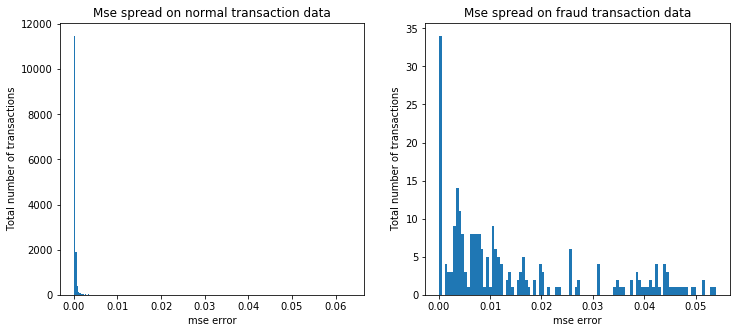

In [12]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
normal_error_df = error_df_test[(error_df_test['true_class']== 0) & (error_df_test['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=200)
plt.title("Mse spread on normal transaction data")
plt.xlabel("mse error")
plt.ylabel("Total number of transactions")

ax = plt.subplot(1,2,2)
fraud_error_df = error_df_test[error_df_test['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=100)
plt.title("Mse spread on fraud transaction data")
plt.xlabel("mse error")
plt.ylabel("Total number of transactions")


In [13]:
error_df_test["predicted_class"]=[1 if x > 0.001 else 0 for x in error_df_test["reconstruction_error"]]

In [14]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

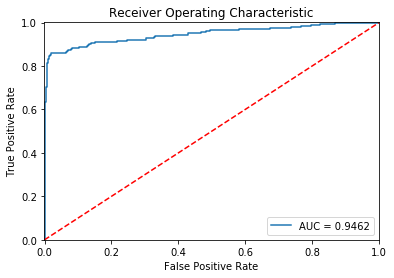

In [15]:
fpr, tpr, thresholds = roc_curve(error_df_test.true_class, error_df_test.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();


In [16]:
print(classification_report(error_df_test["true_class"],error_df_test["predicted_class"]))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     14216
           1       0.33      0.86      0.48       246

    accuracy                           0.97     14462
   macro avg       0.67      0.92      0.73     14462
weighted avg       0.99      0.97      0.98     14462



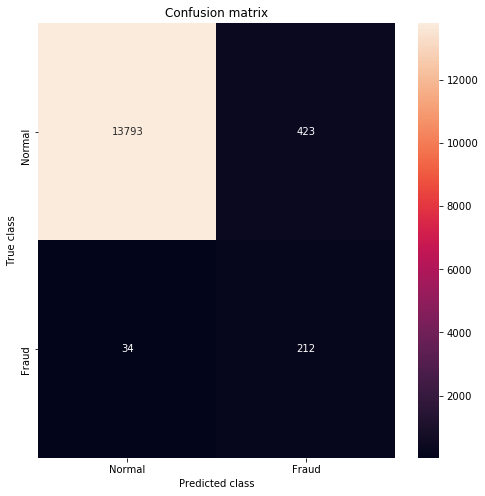

In [17]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > 0.001 else 0 for e in error_df_test.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.true_class,error_df_test.predicted_class)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Analysis on validation set 2

In [18]:
mse = np.mean(np.power(x_val_2 - predictions_val_2, 2), axis=1)
error_df_test = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_val_2.ravel()})
error_df_test.describe()

,reconstruction_error,true_class
count,13751.000000,13751.000000
mean,0.000537,0.017890
std,0.002885,0.132555
min,0.000018,0.000000
25%,0.000125,0.000000
50%,0.000193,0.000000
75%,0.000300,0.000000
max,0.063042,1.000000


Text(0, 0.5, 'Total number of transactions')

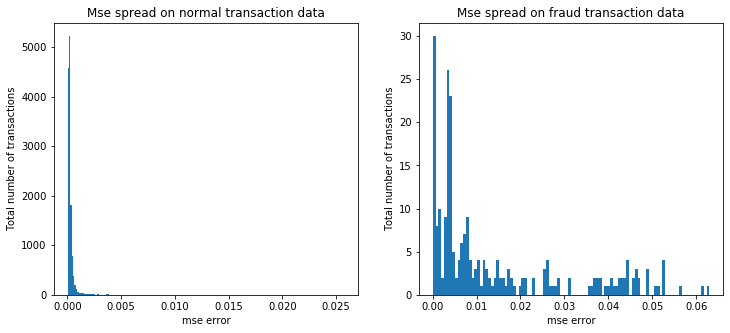

In [19]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
normal_error_df = error_df_test[(error_df_test['true_class']== 0) & (error_df_test['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=200)
plt.title("Mse spread on normal transaction data")
plt.xlabel("mse error")
plt.ylabel("Total number of transactions")

ax = plt.subplot(1,2,2)
fraud_error_df = error_df_test[error_df_test['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=100)
plt.title("Mse spread on fraud transaction data")
plt.xlabel("mse error")
plt.ylabel("Total number of transactions")


In [20]:
error_df_test["predicted_class"]=[1 if x > 0.001 else 0 for x in error_df_test["reconstruction_error"]]

In [21]:
print(classification_report(error_df_test["true_class"],error_df_test["predicted_class"]))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     13505
           1       0.37      0.85      0.51       246

    accuracy                           0.97     13751
   macro avg       0.68      0.91      0.75     13751
weighted avg       0.99      0.97      0.98     13751



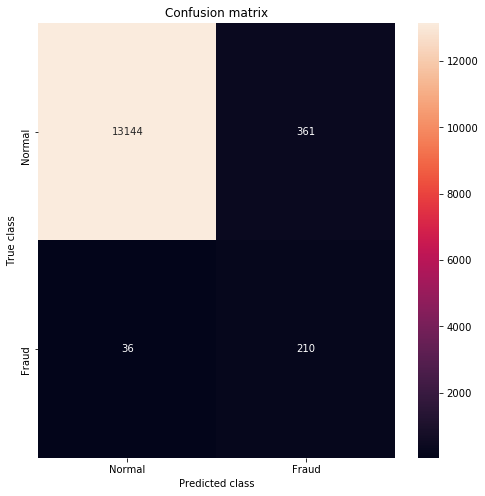

In [22]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > 0.001 else 0 for e in error_df_test.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.true_class,error_df_test.predicted_class)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()